### Part b): Writing your own Neural Network code

Your aim now, and this is the central part of this project, is to
write your own FFNN code implementing the back
propagation algorithm discussed in the lecture slides from week 41 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week41.html> and week 42 at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week42.html>.

We will focus on a regression problem first, using the one-dimensional Runge function

$$
f(x) = \frac{1}{1+25x^2},
$$

from project 1.

Use only the mean-squared error as cost function (no regularization terms) and 
write an FFNN code for a regression problem with a flexible number of hidden
layers and nodes using only the Sigmoid function as activation function for
the hidden layers. Initialize the weights using a normal
distribution. How would you initialize the biases? And which
activation function would you select for the final output layer?
And how would you set up your design/feature matrix? Hint: does it have to represent a polynomial approximation as you did in project 1? 

Train your network and compare the results with those from your OLS
regression code from project 1 using the one-dimensional Runge
function.  When comparing your neural network code with the OLS
results from project 1, use the same data sets which gave you the best
MSE score. Moreover, use the polynomial order from project 1 that gave you the
best result.  Compare these results with your neural network with one
and two hidden layers using $50$ and $100$ hidden nodes, respectively.

Comment your results and give a critical discussion of the results
obtained with the OLS code from project 1 and your own neural network
code.  Make an analysis of the learning rates employed to find the
optimal MSE score. Test both stochastic gradient descent
with RMSprop and ADAM and plain gradient descent with different
learning rates.

You should, as you did in project 1, scale your data.

## Imports

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib, prepare_data, neural_network
importlib.reload(prepare_data)
importlib.reload(neural_network)

# --- Our own code ---
from neural_network import NeuralNetwork
from optimizers import SGD, RMSprop, Adam
from losses import mse, mse_deriv
from activations import sigmoid, sigmoid_deriv, linear, linear_deriv, relu, relu_deriv
from prepare_data import prepare_data

## Prepare data

In [297]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

## Building the Neural Network

In [298]:
layer_output_sizes = [20, 10,1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv

nn = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der)


## Training the network

In [299]:
lr = 1e-2
optimizer = Adam(lr=lr)
history = nn.fit(x_train, 
                 y_train,
                 epochs=500,
                 batch_size=32,
                 optimizer=optimizer,
                 X_val = x_test,
                 Y_val = y_test,
                 log_every=10)

Epoch  10 | train: 0.082500 | val: 0.075145
Epoch  20 | train: 0.081890 | val: 0.078086
Epoch  30 | train: 0.079425 | val: 0.071309
Epoch  40 | train: 0.071785 | val: 0.061914
Epoch  50 | train: 0.053298 | val: 0.043844
Epoch  60 | train: 0.026188 | val: 0.021091
Epoch  70 | train: 0.009536 | val: 0.006047
Epoch  80 | train: 0.004334 | val: 0.002442
Epoch  90 | train: 0.002162 | val: 0.001055
Epoch 100 | train: 0.001191 | val: 0.000518
Epoch 110 | train: 0.000621 | val: 0.000255
Epoch 120 | train: 0.000394 | val: 0.000173
Epoch 130 | train: 0.000249 | val: 0.000091
Epoch 140 | train: 0.000181 | val: 0.000075
Epoch 150 | train: 0.000141 | val: 0.000050
Epoch 160 | train: 0.000117 | val: 0.000044
Epoch 170 | train: 0.000099 | val: 0.000047
Epoch 180 | train: 0.000085 | val: 0.000044
Epoch 190 | train: 0.000077 | val: 0.000048
Epoch 200 | train: 0.000068 | val: 0.000042
Epoch 210 | train: 0.000063 | val: 0.000042
Epoch 220 | train: 0.000057 | val: 0.000037
Epoch 230 | train: 0.000062 | va

## Plotting the fit

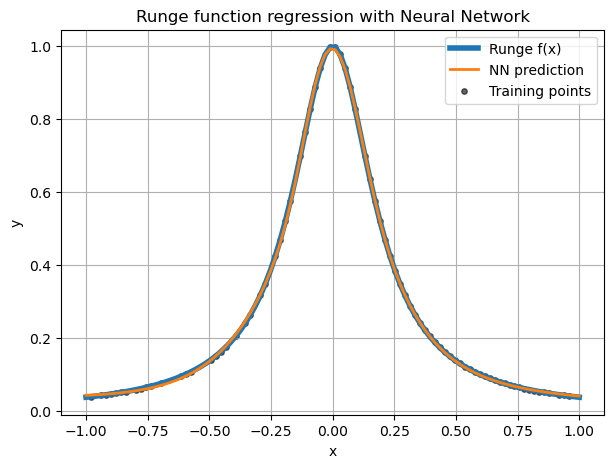

In [300]:
x_plot = x
y_true = y  
x_plot_scaled = scaler_x.transform(x_plot)
y_pred = nn.predict(x_plot_scaled)

x_train_unscaled = scaler_x.inverse_transform(x_train)

# --- 2) Plot sammenligning ---
plt.figure(figsize=(7, 5))
plt.plot(x_plot, y_true, label="Runge f(x)", linewidth=4)
plt.plot(x_plot, y_pred, label="NN prediction", linewidth=2)
plt.scatter(x_train_unscaled, y_train, color="black", s=15, alpha=0.6, label="Training points")
plt.title("Runge function regression with Neural Network")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()